<a href="https://colab.research.google.com/github/geunsu-jo/KCYPS_project/blob/main/201611533_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [153]:
import numpy as np
import pandas as pd

In [209]:
train_data = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/train_data.xlsx")
test_data = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/test_data.xlsx")

In [210]:
train_data.shape, test_data.shape

((1950, 135), (488, 135))

__target__ 데이터 생성

In [211]:
y_train_raw = train_data["y"]
y_test = test_data["y"]

__feature__데이터 생성

In [212]:
X_train_raw = train_data.drop(['y'], axis=1)
X_test = test_data.drop(['y'], axis=1)
X_train_raw.head(3)

,YTIM1A01w2,YTIM1B01w2,YTIM1B02w2,YTIM1C01w2,YTIM1A03w2,YTIM1A04w2,YTIM1B04w2,YTIM1C02w2,YTIM1D01w2,YTIM1H02w2,YTIM1K01w2,YTIM1K02w2,YTIM1L01w2,YTIM1L02w2,YTIM1N02w2,YINT1B00w2,YINT2A02w2,YINT2A03w2,YINT2A08w2,YINT2A10w2,YINT2A11w2,YINT2A14w2,YINT2A15w2,YINT2B01w2,YINT2B02w2,YINT2B03w2,YINT2B08w2,YINT2B09w2,YINT2B11w2,YINT2B12w2,YINT2B13w2,YINT2B16w2,YFUR1A00w2,YFUR2A02w2,YFUR2A04w2,YFUR2A07w2,YFUR2A08w2,YPSY1A05w2,YPSY4A01w2,YPSY4A02w2,...,YEDU3A12w2,YEDU3A14w2,YFAM1A03w2,YFAM2A04w2,YFAM2B01w2,YFAM2B02w2,YFAM2C03w2,YFAM2D04w2,YFAM2E02w2,YFAM2E04w2,YFAM2F02w2,YFAM2F04w2,PPSY1A01w2,PPSY1A02w2,PPSY1A05w2,PPSY2A01w2,PPSY2A02w2,PPSY2A04w2,PPSY3A01w2,PPSY3A04w2,PPSY3A05w2,PPSY3A06w2,PPSY3A07w2,PPSY4A02w2,PPSY4A04w2,PPSY4A06w2,PPSY4A08w2,PPSY4A09w2,PPSY4A21w2,PPSY4A24w2,PPSY4A25w2,PPSY4A28w2,PPSY4A29w2,PPSY4Ascw2,PPSY5A01w2,PPSY5A08w2,PPHY1A00w2,PPHY1B00w2,PPHY1C00w2,PPHY2B00w2
0,7,22,0,4,9,0,30,3,3,3,3,3,4,4,5,4,4,4,3,3,4,3,3,1,1,1,1,1,1,2,2,1,3,4,3,3,8,4,2,1,...,4,4,8,4,2,1,4,1,4,4,2,1,4,3,3,4,3,1,4,4,1,1,4,1,0,1,0,1,0,1,0,0,0,5,3,3,3,2,3,60
1,7,23,0,2,10,30,20,3,3,3,4,6,3,1,5,4,3,3,3,3,3,2,3,3,2,3,2,3,3,3,3,3,4,4,8,4,8,3,2,2,...,3,3,3,3,3,2,3,2,3,3,2,2,2,3,3,3,3,2,3,3,2,2,3,0,0,0,1,1,0,0,1,0,0,2,3,3,3,2,4,70
2,8,24,0,4,10,0,0,4,4,1,5,6,4,5,5,3,2,1,1,1,1,1,2,3,3,3,3,4,2,1,4,4,3,3,8,2,8,1,1,2,...,1,1,3,3,4,2,3,1,4,4,2,2,3,3,1,3,3,1,3,4,1,1,4,0,0,0,0,1,0,1,1,0,0,5,1,3,2,5,7,75


__훈련, 검증 세트 나누기__

In [397]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X_train_raw, y_train_raw, random_state=42)

__SMOTE__

In [398]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train_over,y_train_over = smote.fit_sample(X_train, y_train)
print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트: ', X_train_raw.shape, y_train_raw.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트: ', X_train_over.shape, y_train_over.shape)
print('SMOTE 적용 후 레이블 값 분포: \n', pd.Series(y_train_over).value_counts())

SMOTE 적용 전 학습용 피처/레이블 데이터 세트:  (1950, 134) (1950,)
SMOTE 적용 후 학습용 피처/레이블 데이터 세트:  (1990, 134) (1990,)
SMOTE 적용 후 레이블 값 분포: 
 1    995
0    995
dtype: int64


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


__표준화__

In [399]:
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()
X_train_scaled = std_scaler.fit_transform(X_train_over)
X_valid_scaled = std_scaler.transform(X_valid)
X_test_scaled = std_scaler.transform(X_test)

DNN

In [400]:
import tensorflow as tf
from tensorflow import keras

tf.__version__

'2.4.0'

In [401]:
model = keras.models.Sequential([
                                 keras.layers.Dense(30, activation="relu", input_shape=X_train_scaled.shape[1:]),
                                 keras.layers.BatchNormalization(),
                                 keras.layers.Dense(30, activation="relu"),
                                 keras.layers.BatchNormalization(),
                                 keras.layers.Dense(30, activation="relu"),
                                 keras.layers.BatchNormalization(),
                                 keras.layers.Dense(1, activation="sigmoid")
])
model.compile(loss=keras.losses.binary_crossentropy,
              optimizer=keras.optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.99),
              metrics=[keras.metrics.binary_accuracy])

In [403]:
history = model.fit(X_train_scaled, y_train_over, epochs=30,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/30
63/63 [==============================] - 0s 3ms/step - loss: 0.1181 - binary_accuracy: 0.9673 - val_loss: 0.9476 - val_binary_accuracy: 0.6701
Epoch 2/30
63/63 [==============================] - 0s 3ms/step - loss: 0.1189 - binary_accuracy: 0.9598 - val_loss: 0.9619 - val_binary_accuracy: 0.6742
Epoch 3/30
63/63 [==============================] - 0s 2ms/step - loss: 0.1280 - binary_accuracy: 0.9497 - val_loss: 0.9705 - val_binary_accuracy: 0.6639
Epoch 4/30
63/63 [==============================] - 0s 2ms/step - loss: 0.1082 - binary_accuracy: 0.9673 - val_loss: 1.0114 - val_binary_accuracy: 0.6537
Epoch 5/30
63/63 [==============================] - 0s 2ms/step - loss: 0.1156 - binary_accuracy: 0.9588 - val_loss: 1.0288 - val_binary_accuracy: 0.6619
Epoch 6/30
63/63 [==============================] - 0s 2ms/step - loss: 0.0936 - binary_accuracy: 0.9714 - val_loss: 1.0578 - val_binary_accuracy: 0.6475
Epoch 7/30
63/63 [==============================] - 0s 2ms/step - loss: 0.09

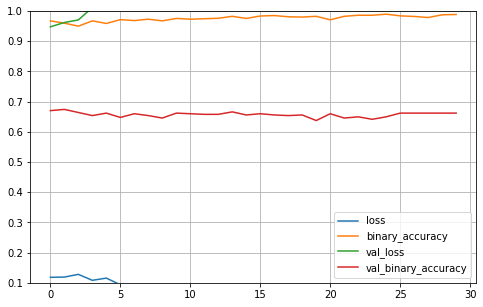

In [404]:
import pandas as pd
import matplotlib.pyplot as plt

pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0.1,1)
plt.show()

In [227]:
model.evaluate(X_test_scaled,y_test_raw)

16/16 [==============================] - 0s 1ms/step - loss: 0.9317 - binary_accuracy: 0.6434


[0.931732177734375, 0.6434426307678223]

In [233]:
np.mean(y_valid==1)

0.7049180327868853

## 랜포

In [406]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score


param_n = [200,250,300,350,400]
rf_score = []
for n in param_n:
    rfc = RandomForestClassifier(n_jobs=-1, n_estimators=n, random_state=42)
    rfc.fit(X_train_scaled, y_train_over)
    y_pred = rfc.predict(X_valid_scaled)
    rf_score.append(recall_score(y_valid, y_pred))

rf_score

[0.8372093023255814,
 0.8459302325581395,
 0.8604651162790697,
 0.8604651162790697,
 0.8604651162790697]

- n_estimators=300 일 때, recall이 최대

In [407]:
rfc_best = RandomForestClassifier(n_jobs=-1, n_estimators=300, random_state=42)
rfc_best.fit(X_train_scaled, y_train_over)
y_pred_rf = rfc_best.predict(X_test_scaled)
recall_score(y_test, y_pred_rf)

0.8601823708206687

## 부스팅

In [420]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import recall_score

gbrt = GradientBoostingClassifier(max_depth=2, n_estimators=1000, random_state=42)
gbrt.fit(X_train_scaled, y_train_over)

# n_estimators=200이므로, score의 길이는 200 
# score는 재현율(recall)
scores = [recall_score(y_valid, y_pred)
          for y_pred in gbrt.staged_predict(X_valid_scaled)] 

bst_n_estimators = np.argmax(scores) + 1

gbrt_best = GradientBoostingClassifier(max_depth=2, n_estimators=bst_n_estimators, random_state=42)
gbrt_best.fit(X_train_scaled, y_train_over)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=2,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=758,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=42, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [421]:
max_score = np.max(scores)
bst_n_estimators, max_score

(758, 0.8401162790697675)

Text(758, 0.7393023255813954, 'Recall')

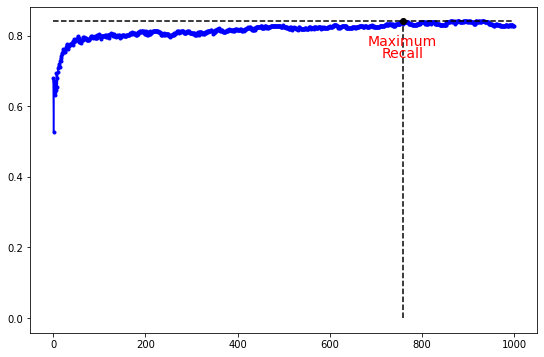

In [423]:
plt.figure(figsize=(20, 6))

plt.subplot(121)
plt.plot(scores, "b.-")
plt.plot([bst_n_estimators, bst_n_estimators], [0, max_score], "k--")
plt.plot([0, 1000], [max_score, max_score], "k--")
plt.plot(bst_n_estimators, max_score, "ko")
plt.text(bst_n_estimators, max_score*0.92, "Maximum", ha="center", fontsize=14, color="red")
plt.text(bst_n_estimators, max_score*0.88, "Recall", ha="center", fontsize=14, color="red")

In [424]:
y_pred_gb = gbrt_best.predict(X_test_scaled)
recall_score(y_test, y_pred_gb)

0.7689969604863222